In [1]:
!nvidia-smi

Fri Mar 10 14:58:20 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [8]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = "Pancreas-CT"

In [9]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "data", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "TCIA_pancreas_labels-02-05-2017", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
print(len(data_dicts))

82


In [25]:
train_files, val_files = data_dicts[:60], data_dicts[60:]
target_layer=100
set_determinism(seed=0)

In [26]:
def nii_loader(filename) :
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt
    nimg = nib.load( filename )
    return nimg.get_fdata() , nimg.affine, nimg.header 

def visualize( dataset, idx=0, target_layer=10 ):
    import matplotlib.pyplot as plt    

    image = dataset[idx]['image']
    label = dataset[idx]['label']

    image_data, image_affine, image_header = nii_loader(image)
    label_data, label_affine,   label_header = nii_loader(label)

    print(image_data.shape, label_data.shape )
    target_image = image_data[:,:,target_layer]
    target_label = label_data[:,:,target_layer]

    fig, (ax1, ax2) = plt.subplots(1, 2 ,  figsize=(12,8))

    ax1.imshow(target_image, cmap='gray' )
    ax1.set_title('image')
    ax2.imshow(target_label )
    ax2.set_title('GT segmentation')
    plt.show()

(512, 512, 216) (512, 512, 216)


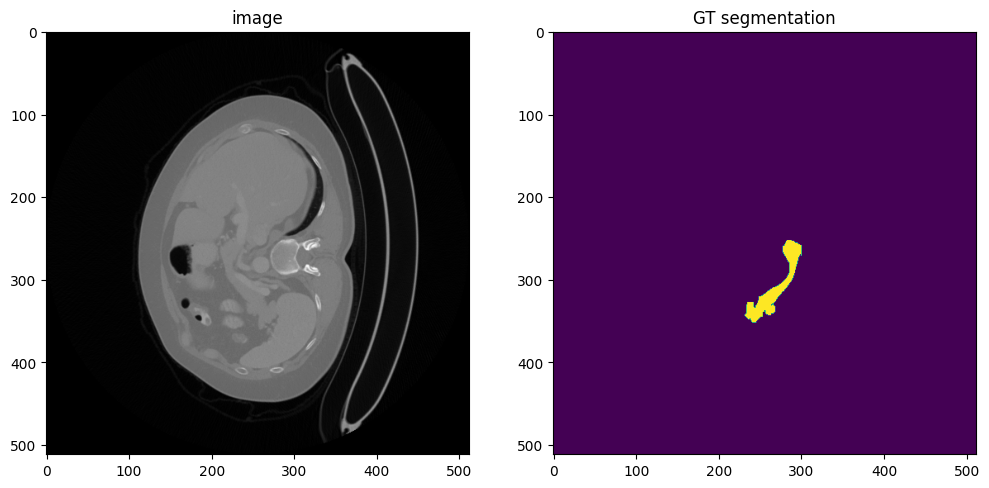

In [27]:
visualize( val_files, idx=4,  target_layer=target_layer)

In [28]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandAffined,
)

In [29]:
from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(48, 48, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([302, 215, 112]), label shape: torch.Size([302, 215, 112])


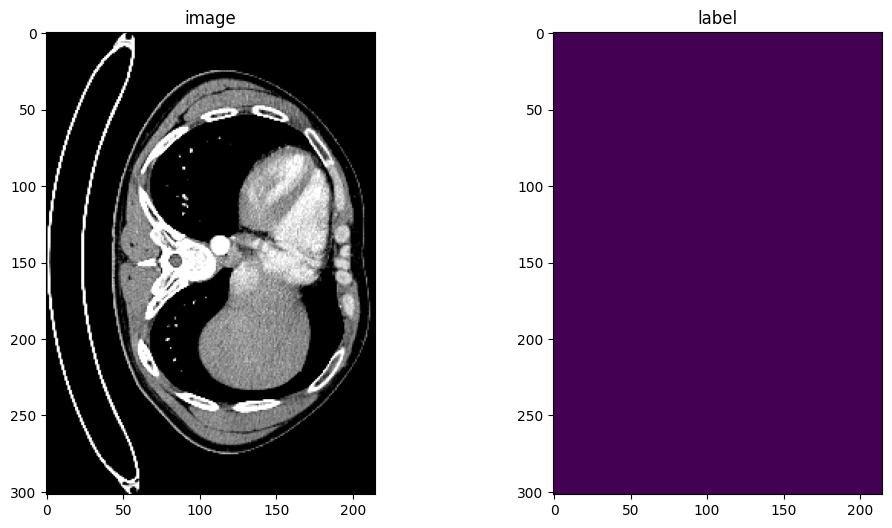

In [30]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, target_layer], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, target_layer])
plt.show()

In [31]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4, progress=True)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████████████████████| 22/22 [00:34<00:00,  1.55s/it]


In [32]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm


device = torch.device("cuda:0")
out_channels = 2
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=out_channels,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [33]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [34]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [35]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=out_channels)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=out_channels)])
model_name = 'UNet'

In [36]:
%%time 

import time 

for epoch in range(max_epochs):
    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(
                f"\nepoch {epoch + 1}/{max_epochs}"
                f" steps {step}/{len(train_ds) // train_loader.batch_size}, "
                f"|train_loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            #print( "| Val Dice metric {:6.4f}".format(metric) , end='')
            # reset the status for next validation round
            dice_metric.reset()

            
            metric_values.append(metric)
            print(
                f"|DICE cur: {metric:.4f}"
                f" old best : {best_metric:.4f} "
                f"at {best_metric_epoch}" , end=''            )
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_best.pth".format(model_name)))
                torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_best.pth".format(model_name)))
                print("|best model saved", end='')            

    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_{:04d}.pth".format(model_name, epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_{:04d}.pth".format(model_name, epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(
    f"\ntrain completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
    f" for {max_epochs} epoches" )


epoch 1/100 steps 5/30, |train_loss: 0.6468
epoch 1/100 steps 10/30, |train_loss: 0.6627
epoch 1/100 steps 15/30, |train_loss: 0.6374
epoch 1/100 steps 20/30, |train_loss: 0.6249
epoch 1/100 steps 25/30, |train_loss: 0.6266
epoch 1/100 steps 30/30, |train_loss: 0.6248 |avg loss: 0.6432 dur 89.7s 
epoch 2/100 steps 5/30, |train_loss: 0.6216
epoch 2/100 steps 10/30, |train_loss: 0.6343
epoch 2/100 steps 15/30, |train_loss: 0.6058
epoch 2/100 steps 20/30, |train_loss: 0.6316
epoch 2/100 steps 25/30, |train_loss: 0.6133
epoch 2/100 steps 30/30, |train_loss: 0.6171 |avg loss: 0.6190 dur 89.6s |DICE cur: 0.0118 old best : -1.0000 at -1|best model saved
epoch 3/100 steps 5/30, |train_loss: 0.5834
epoch 3/100 steps 10/30, |train_loss: 0.6163
epoch 3/100 steps 15/30, |train_loss: 0.6100
epoch 3/100 steps 20/30, |train_loss: 0.5994
epoch 3/100 steps 25/30, |train_loss: 0.6211
epoch 3/100 steps 30/30, |train_loss: 0.5954 |avg loss: 0.6104 dur 88.5s 
epoch 4/100 steps 5/30, |train_loss: 0.5992
ep

In [37]:
!rm -rf pymp-*

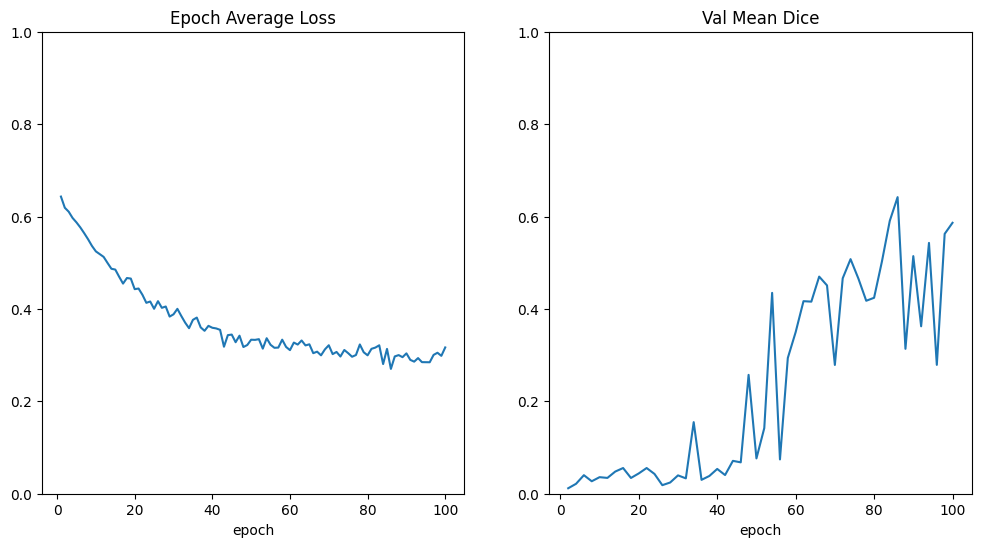

In [38]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()

In [39]:
def inference_segment(model, roi_size, sw_batch_size, num_data=2):
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_data["image"].to(device), roi_size, sw_batch_size, model
            )
            # plot the slice [:, :, target_layer]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, target_layer], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, target_layer])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, target_layer])
            plt.show()
            if i == num_data:
                break                
    
def inference_segment_best(work_dir, model, roi_size, sw_batch_size, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "{}_model_best.pth".format(model_name))))
    model.eval()
    inference_segment(model, roi_size, sw_batch_size, num_data)

def inference_segment_epoch(work_dir, model, roi_size, sw_batch_size, epoch=30, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "{}_model_{:04d}.pth".format(model_name, epoch))))
    model.eval()
    inference_segment(model, roi_size, sw_batch_size, num_data)

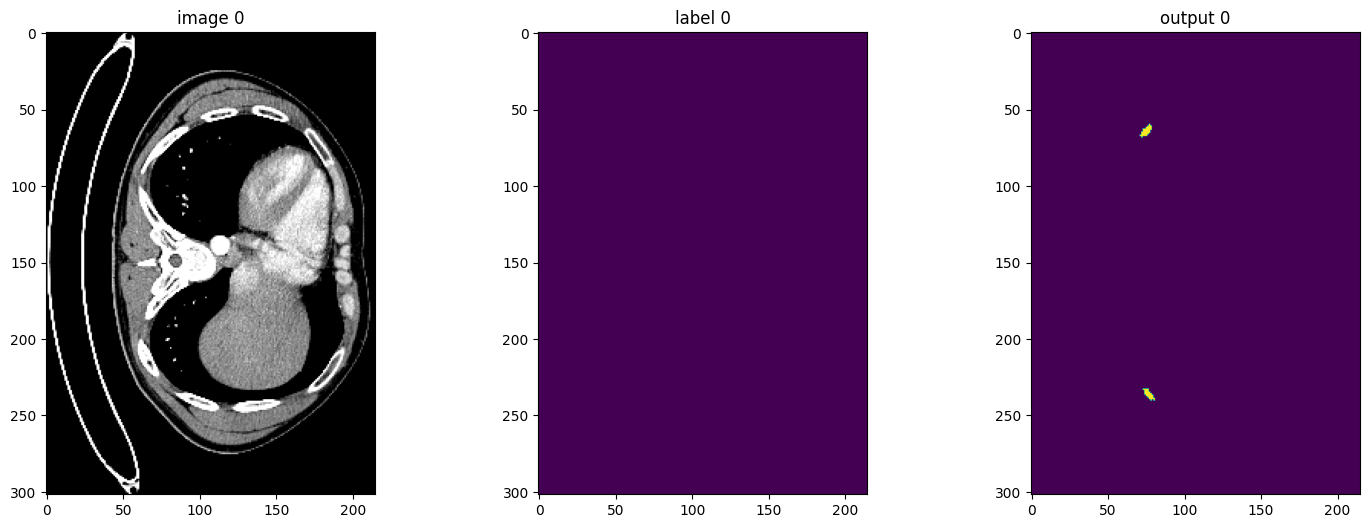

In [40]:
roi_size = (160, 160, 160)
sw_batch_size = 4
inference_segment_best(root_dir, model, roi_size, sw_batch_size, num_data=0)

In [41]:
!ls -alh temp/*.pth

-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 15:28 temp/UNet_model_0010.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 15:45 temp/UNet_model_0020.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 16:02 temp/UNet_model_0030.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 16:20 temp/UNet_model_0040.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 16:37 temp/UNet_model_0050.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 16:54 temp/UNet_model_0060.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 17:12 temp/UNet_model_0070.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 17:29 temp/UNet_model_0080.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 17:46 temp/UNet_model_0090.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 18:04 temp/UNet_model_0100.pth
-rw-rw-r-- 1 aistore3 aistore3 19M Mar 10 17:39 temp/UNet_model_best.pth
-rw-rw-r-- 1 aistore3 aistore3 37M Mar 10 15:28 temp/UNet_optim_0010.pth
-rw-rw-r-- 1 aistore3 aistore3 37M Mar 10 15:45 temp/UNet_optim_0020.pth
-rw-rw-r-- 1 aistore3 aistore3 37M Mar 10 16:02 tem

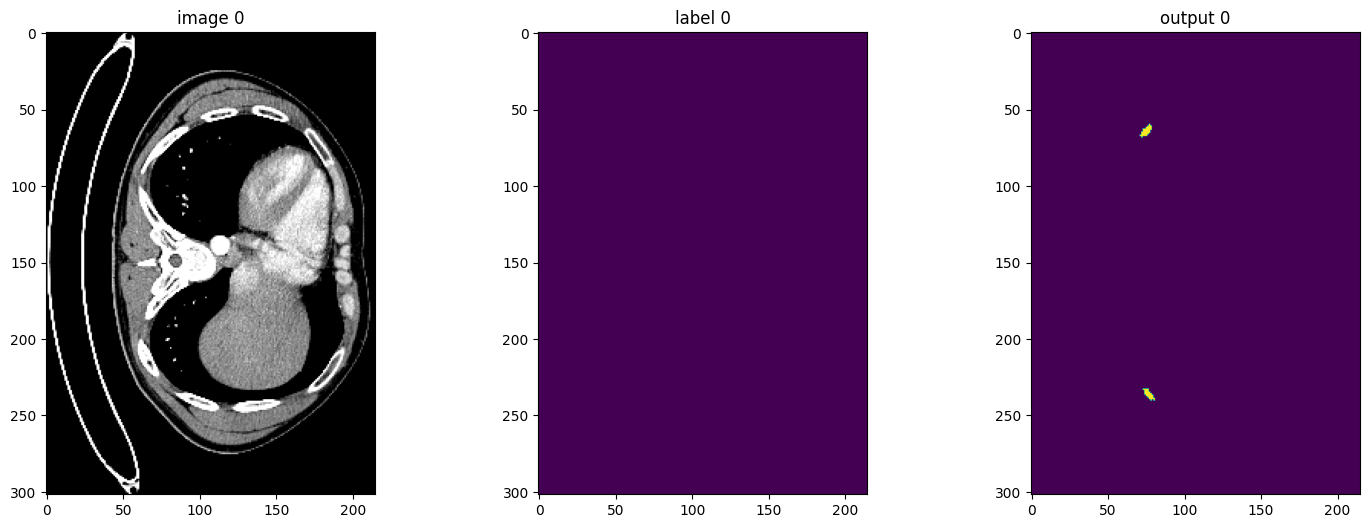

RuntimeError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 0; 31.75 GiB total capacity; 1.30 GiB already allocated; 129.50 MiB free; 1.91 GiB reserved in total by PyTorch)

In [42]:
inference_segment_best(root_dir, model, roi_size, sw_batch_size, num_data=5)